# Want to calculate the moments of different power spectra

In [125]:
#set up and fixed power spectra to work with (based on 2019-07-18 Synch maps spatial variation)


#------packages-------------------
%pylab inline

import healpy as hp

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)

Populating the interactive namespace from numpy and matplotlib


In [126]:
"""
----Notation used in this notebook----

ells    - the ells up to ell_max = 384
pcls    - the power law C_ell defined through pcls = (ell/80)^alpha_BB
check_cls - the extracted C_ell from a map using anafast

sbb     - the power law map in ell. This will be used for all complete maps, as we're only modifying the frequency dep.


sed_scaling_<x> - the scaled_synch function on frequencies and some beta. Up to unit conversion this is (nu/nu_0)^beta
                  where beta is either just a constant or is a whole map of betas


newmaps_<x>    - newmaps_<x> = sbb * sed_scaling_<x>. This is a series of 'real' frequency maps

""";

In [127]:
#define C_ell with a power law dependence on ell
#pcls for Power law C_Ls
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0

#shift the ells to start at 0
#ells = ells-1


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


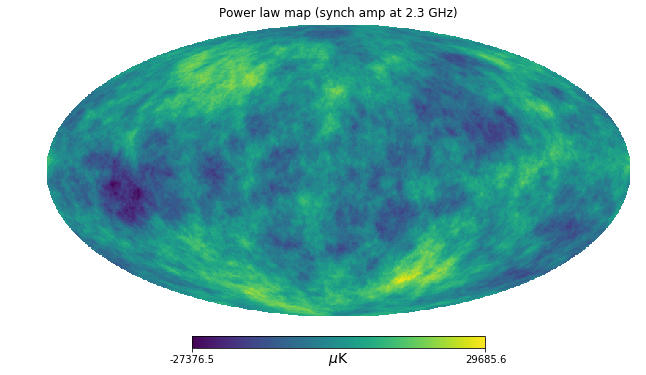

In [128]:
#-----AMPLITUDE MAP----------
sbb = hp.synfast(pcls, nside, new=True)
hp.mollview(sbb, unit=r'$\mu \rm K$', title='Power law map (synch amp at 2.3 GHz)')



In [129]:
#----AMPLITUDE MAP---------------------------
#these are the amplitude cls
check_pcls = hp.anafast(sbb)

In [130]:
#SED maps---constant beta-------

#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9

#define the SED scaling
sed_scaling = scale_synch(freqs, beta_BB)

#the maps including SED at different frequencies
newmaps = sbb * sed_scaling[..., np.newaxis]


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


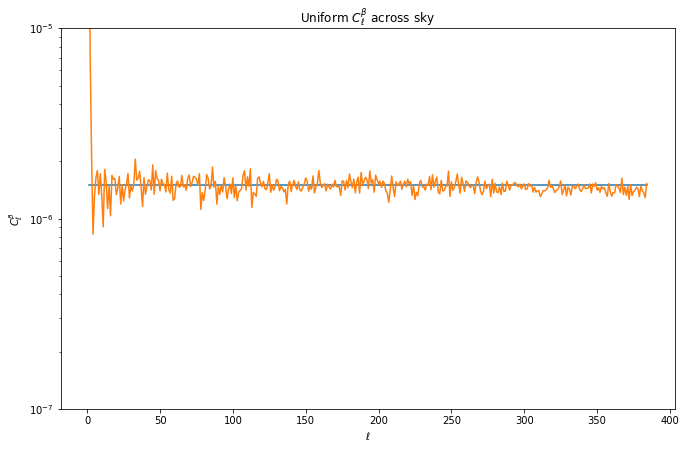

In [131]:
#varying beta
beta_sigma = 1.5e-6

#define a 'beta map' using uniform C_ell
bcls = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map = hp.synfast(bcls, nside, new=True)
#update the map so that the mean is correct
beta_map -= (np.mean(beta_map) + 3.2)


#drawn out beta cls
check_bcls = hp.anafast(beta_map)

figure(figsize=(11,7))
semilogy(ells, bcls)
semilogy(ells, check_bcls)
ylim(1e-7, 1e-5)
xlabel("$\ell$")
ylabel(r"$ C_\ell^{\beta}$") 
title(r"Uniform $C_\ell^\beta$ across sky");


In [132]:
#make series of beta maps
sed_scaling_beta = scale_synch(freqs, beta_map).T

#make ''realistic maps'' from sbb*new SED
newmaps_beta = sbb * sed_scaling_beta

In [133]:
'''
Maps made at this stage:

Frequency amplitude maps -- in paper called Sy -- in code called sbb
Beta map -- in paper called beta_s -- in code called beta_map
Realistic maps -- in code called newmaps, newmaps_beta
''';

In [134]:
#let's make some cross spectra

In paper, equation (35):
$$
C_\ell^{\nu_1\nu_2}(1\times 1) = \partial_{\beta_s}\mathrm{Sy}^{\nu_1}\partial_{\beta_s}\mathrm{Sy}^{\nu_2}\sum_{\ell_1\ell_2}\frac{(2\ell_1+1)(2\ell_2+1)}{4\pi}\begin{pmatrix} \ell & \ell_1 & \ell_2 \\ 0 & 0 & 0 \end{pmatrix}^2 \langle \mathrm{Sy}\mathrm{Sy}\rangle_{\ell_1}\langle \beta_s \beta_s \rangle_{\ell_2}
$$

In terms of code parameters
$$
C_\ell^{\nu_1\nu_2}(1\times 1) = \partial_{\beta_s}\mathrm{SED}^{\nu_1}\partial_{\beta_s}\mathrm{SED}^{\nu_2} \sum_{\ell_1\ell_2} \mathrm{normalisation} * (W^{\ell,\ell_1,\ell_2}_{0,0,0})^2 * \texttt{check_pcls[ell_1]} * \texttt{check_bcls[ell_2]}
$$

In [135]:
from pyshtools.utils import Wigner3j

In [136]:
       '''
        to find the symbol / i ell1 ell2 \
                           \ 0  0    0   /
        for a particular i, we check that i is in the range of [ellmin, ellmax]. If it isn't, then
        this symbol is 0. If it is, then it is at the (i-ellmin)th position in the array w3j. e.g. The symbol
        / ell 2  2 \
        \ 0   0  0 /
        produces a w3j of 
        
        [ 0.4472136   0.         -0.23904572  0.          0.23904572]
        
        (ell = 0      ell = 1     ell = 2     ell = 3     ell = 4)
        as the ellmin,ellmax is 0,4 for these symbols. Thus 
        / 2 2 2 \
        \ 0 0 0 / = -0.23904572 etc
        ''';

In [137]:
#testing with small arrays first to try to understand what's happening

miniells = np.array([0,1,2,3])
moment1x1 = np.zeros_like(miniells)

for ell1 in miniells:
    for ell2 in miniells:
        #finds all the non-zero wigner 3j coefficients compatible with the other 5 numbers
        #returns w3j, an array of these 3j coefficients
        #returns ellmin, the j corresponding to the first non-zero of w3j
        #returns ellmax, the j corresponding to the last non-zero of w3j
        w3j, ellmin, ellmax = Wigner3j(ell1, ell2, 0, 0, 0)
        avaliable_ells = np.arange(ellmin, ellmax+1)
        
        #define the normalisation factor in above equation
        factor = (2 * ell1 + 1)*(2 * ell2 + 1)/(4*pi)
        
        #the auto spectra are from the C_ells calculated earlier in this notebook
        synch_cls = check_pcls[ell1]
        beta_cls = check_bcls[ell2]
        
        print("(ell1,ell2) = (" + str(ell1) + ',' +str(ell2) + ')')
        print('w3j = ')
        print(w3j)
        #print("ellmin--ellmax = " +str(ellmin) +'--' + str(ellmax))
        print('avaliable ell = ' +str(np.arange(ellmin, ellmax+1)))
        print("")
        
        moment1x1_1 = 0
        #this makes the sum of the squares of the non-zero (1 ell1 ell2) symbols, with ell1, ell2 in miniells
        if ellmin > 1 or ellmax < 1:
            moment1x1_1 += 0
        else:
            w3j_1 = w3j[ellmin-1]
            moment1x1_1 += w3j_1**2 #* factor * synch_cls * beta_cls

        
        
        #try again
        for i in range(len(miniells)):
            if i in avaliable_ells:
                moment1x1[i] += w3j[i-ellmin]**2
            else:
                moment1x1[i] += 0
        
        
        #want to try to do this with an array that we update to become the 1x1 moment cls.
        #not ideal as we're now three loops deep, which will get big fast when ells gets big
        
#         for i in range(len(miniells)):
#             if ellmin > i or ellmax < i:
#                 moment1x1[i] += 0
#             else:
#                 w3j_i = w3j[i-ellmin]
#                 moment1x1[i] += w3j_i**2 #* factor * synch_cls * beta_cls


                
print(moment1x1_1)
print(moment1x1)
        
        




(ell1,ell2) = (0,0)
w3j = 
[1.]
avaliable ell = [0]

(ell1,ell2) = (0,1)
w3j = 
[-0.57735027  0.        ]
avaliable ell = [1]

(ell1,ell2) = (0,2)
w3j = 
[0.4472136 0.        0.       ]
avaliable ell = [2]

(ell1,ell2) = (0,3)
w3j = 
[-0.37796447  0.          0.          0.        ]
avaliable ell = [3]

(ell1,ell2) = (1,0)
w3j = 
[-0.57735027  0.        ]
avaliable ell = [1]

(ell1,ell2) = (1,1)
w3j = 
[-0.57735027  0.          0.36514837]
avaliable ell = [0 1 2]

(ell1,ell2) = (1,2)
w3j = 
[ 0.36514837 -0.         -0.29277002  0.        ]
avaliable ell = [1 2 3]

(ell1,ell2) = (1,3)
w3j = 
[-0.29277002  0.          0.25197632  0.          0.        ]
avaliable ell = [2 3 4]

(ell1,ell2) = (2,0)
w3j = 
[0.4472136 0.        0.       ]
avaliable ell = [2]

(ell1,ell2) = (2,1)
w3j = 
[ 0.36514837 -0.         -0.29277002  0.        ]
avaliable ell = [1 2 3]

(ell1,ell2) = (2,2)
w3j = 
[ 0.4472136   0.         -0.23904572  0.          0.23904572]
avaliable ell = [0 1 2 3 4]

(ell1,ell2) = (

# Generating mean power spectra under many realisations

In [138]:
#define a function that generates an amplitude map given ells and a power for the power spectrum. Obtain its power
#spectrum and then generate a matrix of N realisations of each of the LMax C_ell
'''
[-------power spectrum 1-----------]
[-------power spectrum 2-----------]
               ...
[-------power spectrum N-----------]

''';

def amp_map(ell, alpha):
    input_cls = A_BB * powerlaw(ell, alpha)
    input_cls[0] = 0
    input_cls[1] = 0
    amp_map = hp.synfast(input_cls, nside, new=True)
    output_cls = hp.anafast(amp_map)
    return output_cls

check_pcls.shape
N = 10
bigmat = zeros([N,384])
bigmat[0].shape

(384,)

In [139]:
for i in range(N):
    bigmat[i] += amp_map(ells, alpha_BB)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm